In [1]:
import pickle
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt
from periodictable import elements
from tqdm import tqdm

In [2]:
from exfor_tools.distribution import AngularDistribution

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [3]:
from jitr.optical_potentials import kduq, wlh

In [4]:
import elm

In [5]:
neutron = (1, 0)
proton = (1, 1)

In [6]:
kduq_params_nn = kduq.get_samples_federal(neutron)
kduq_params_pp = kduq.get_samples_federal(proton)

## set up corpora from workspaces

In [7]:
with open("nn_elastic_workspaces.pkl", "rb") as f:
    nn_elastic_workspaces = pickle.load(f)
with open("pp_elastic_workspaces.pkl", "rb") as f:
    pp_elastic_workspaces = pickle.load(f)

In [8]:
%%time
kduq_pp_corpus = elm.corpus.ElasticAngularCorpus(
    kduq.calculate_diff_xs,
    "dXS/dRuth",
    pp_elastic_workspaces,
)

CPU times: user 108 ms, sys: 7.62 ms, total: 116 ms
Wall time: 36.8 ms


In [9]:
%%time
kduq_nn_corpus = elm.corpus.ElasticAngularCorpus(
    kduq.calculate_diff_xs,
    "dXS/dA",
    nn_elastic_workspaces,
)

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 5.81 ms


## visualize cross sections

### $(n,n)$

In [17]:
target = (48,20)
model = []
exp = []

In [10]:
for measurement, ws in nn_elastic_workspaces:
    if ws.reaction.target == target:
        exp.append(measurement)

        th = np.percentile(
            np.vstack(
            [
                kduq.calculate_diff_xs(ws.visualization_workspace, p).dsdo /1000
                for p in kduq_params_nn
            ]
        ), [16,84], axis=0)
        model.append(th)

/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:303: RuntimeWarning: overflow encountered in exp
  1 + np.exp((A - params["d2_A3"]) / params["d2_A2"])


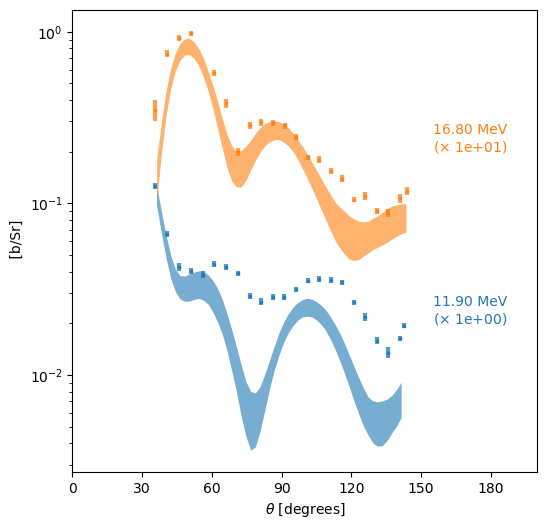

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
offsets = AngularDistribution.plot(exp, ax, offsets=10, label_kwargs={"label_offset_factor": 0.02}, xlim=[0,200])
xth = ws.visualization_workspace.angles*180/np.pi
for measurement, offset, (upper, lower) in zip(exp, offsets, model):
    mask = np.logical_and(xth > np.min(measurement.x) , xth < np.max(measurement.x))
    plt.fill_between(xth[mask], offset*lower[mask], offset * upper[mask], alpha=0.6)

### $(p,p)$

In [47]:
target = (48,20)
model = []
exp = []

In [32]:
for measurement, ws in pp_elastic_workspaces:
    if ws.reaction.target == target and measurement.quantity == "dXS/dRuth":
        
        exp.append(measurement)

        th = np.percentile(
            np.vstack(
            [
                kduq.calculate_diff_xs(ws.visualization_workspace, p).dsdo / ws.visualization_workspace.rutherford
                for p in kduq_params_pp
            ]
        ), [16,84], axis=0)
        model.append(th)

/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:303: RuntimeWarning: overflow encountered in exp
  1 + np.exp((A - params["d2_A3"]) / params["d2_A2"])


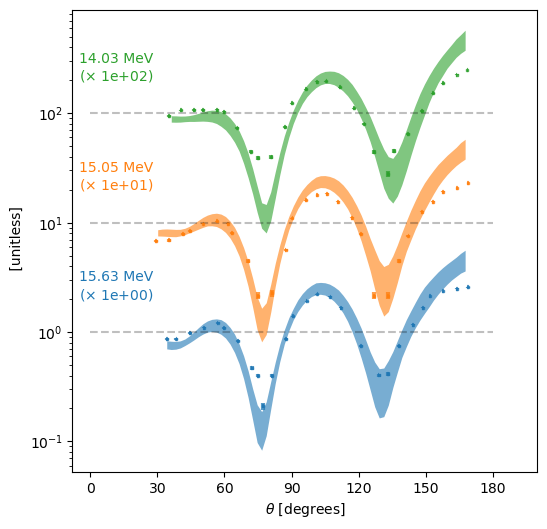

In [38]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
offsets = AngularDistribution.plot(exp, ax, offsets=10, label_kwargs={"label_offset_factor": 2, "label_xloc_deg" : -5}, xlim=[-8,200],  draw_baseline=True, baseline_offset=1)
xth = ws.visualization_workspace.angles*180/np.pi
for measurement, offset, (upper, lower) in zip(exp, offsets, model):
    mask = np.logical_and(xth > np.min(measurement.x) , xth < np.max(measurement.x))
    plt.fill_between(xth[mask], offset*lower[mask], offset * upper[mask], alpha=0.6)

In [45]:
for measurement, ws in pp_elastic_workspaces:
    if ws.reaction.target == target and measurement.quantity == "dXS/dA":
        
        exp.append(measurement)

        th = np.percentile(
            np.vstack(
            [
                kduq.calculate_diff_xs(ws.visualization_workspace, p).dsdo / 1000
                for p in kduq_params_pp
            ]
        ), [16,84], axis=0)
        model.append(th)

ValueError: 'yerr' must not contain negative values

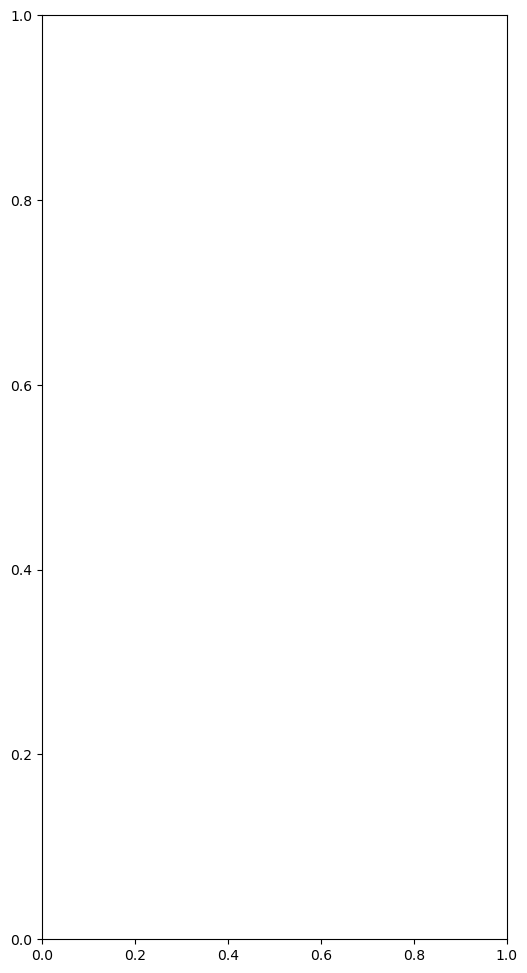

In [46]:
fig, axes = plt.subplots(1,1, figsize=(6,12))
offsets = AngularDistribution.plot(exp, ax, offsets=10, label_kwargs={"label_offset_factor": 0.02, "label_xloc_deg" : 180}, xlim=[0,220])
xth = ws.visualization_workspace.angles*180/np.pi
for measurement, offset, (upper, lower) in zip(exp, offsets, model):
    mask = np.logical_and(xth > np.min(measurement.x) , xth < np.max(measurement.x))
    plt.fill_between(xth[mask], offset*lower[mask], offset * upper[mask], alpha=0.6)

## $\chi^2/ \rm{DOF} $

In [12]:
nparams_nn = len(kduq_params_nn[0])
nparams_pp = len(kduq_params_pp[0])
ndof_nn = kduq_nn_corpus.n_data_pts - nparams_nn
ndof_pp = kduq_pp_corpus.n_data_pts - nparams_pp

In [13]:
%%time
chi2pp = [kduq_pp_corpus.chi2(p) / ndof_pp for p in kduq_params_pp]

/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:303: RuntimeWarning: overflow encountered in exp
  1 + np.exp((A - params["d2_A3"]) / params["d2_A2"])


CPU times: user 24.9 s, sys: 16.2 ms, total: 24.9 s
Wall time: 25 s


In [14]:
%%time
chi2nn = [kduq_nn_corpus.chi2(p) / ndof_nn for p in kduq_params_nn]

CPU times: user 6.87 s, sys: 3.38 ms, total: 6.87 s
Wall time: 6.87 s


(array([ 8., 26., 36., 76., 80., 83., 58., 33., 14.,  2.]),
 array([1.79825158e+10, 1.80865879e+10, 1.81906601e+10, 1.82947322e+10,
        1.83988043e+10, 1.85028765e+10, 1.86069486e+10, 1.87110207e+10,
        1.88150929e+10, 1.89191650e+10, 1.90232371e+10]),
 <BarContainer object of 10 artists>)

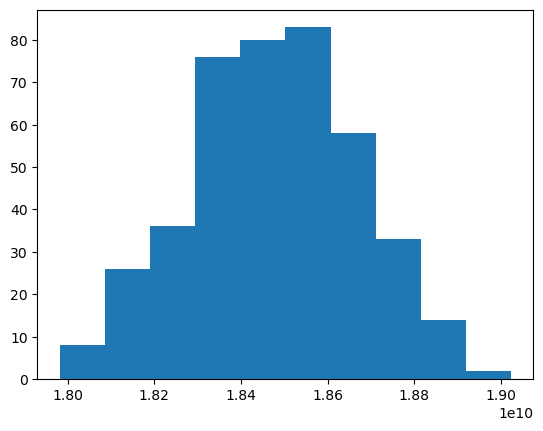

In [15]:
plt.hist(chi2pp)

(array([119., 169.,  72.,  28.,  17.,   3.,   3.,   3.,   0.,   2.]),
 array([25.41227992, 32.53896614, 39.66565237, 46.7923386 , 53.91902483,
        61.04571105, 68.17239728, 75.29908351, 82.42576973, 89.55245596,
        96.67914219]),
 <BarContainer object of 10 artists>)

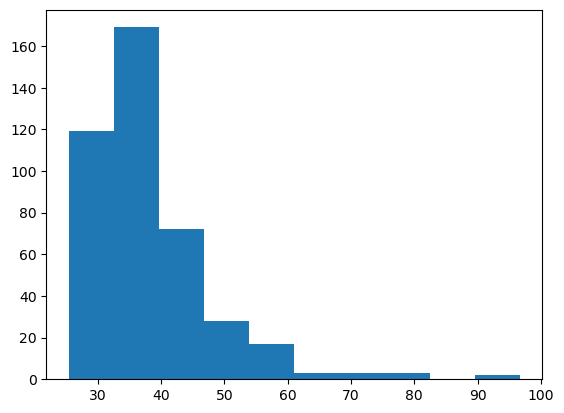

In [16]:
plt.hist(chi2nn)